In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report
import math
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
import graphviz
from matplotlib.colors import ListedColormap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data input

In [2]:
df = pd.read_csv('student/student-mat.csv', sep = ';')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

### Function for plotting confusiun matrix 
> reference from TA's sample code

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes )
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Label G3 to binary or five-class and Shuffle the data

In [4]:
def bi(x):
    if x >= 10:
        return 'pass'
    else:
        return 'fail'
def five(x):
    if x >= 16:
        return 'excellent'
    elif x >= 14:
        return 'good'
    elif x >= 12:
        return 'satisfactory'
    elif x >= 10:
        return 'sufficient'
    else:
        return 'fail'

In [5]:
df['G3_bi'] = df['G3'].apply(lambda x: bi(x))
df['G3_five'] = df['G3'].apply(lambda x: five(x))
df = shuffle(df, random_state =0)
df.reset_index(inplace=True, drop=True)

### Do OHE for categoriacl data

In [6]:
X = df.drop(columns = ['G3', 'G3_bi', 'G3_five']).copy()
X = pd.get_dummies(X)
y_bi = df['G3_bi'].copy()
y_five = df['G3_five'].copy()
# X_train, X_valid, y_train, y_valid = train_test_split(X, y_bi, train_size=0.7, test_size=0.3, random_state=0)

### Function for Holdout Validation

In [7]:
def holdout(clf, X, y, label):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
    clf.fit(X_train, y_train)
    y_true, y_pred = y_valid, clf.predict(X_valid)
    
    print(classification_report(y_true, y_pred, labels = label))
    plot_confusion_matrix(y_true, y_pred, classes=np.array(label), cmap=plt.cm.Blues)
    plt.show()
    
#     dot_data = export_graphviz(clf, out_file=None, 
#                      feature_names=X.columns,  
#                      class_names=y.unique(),  
#                      filled=True,
#                      rounded=True,  
#                      special_characters=True,
#                      )  
#     graph = graphviz.Source(dot_data)
#     return graph

### Function for KFold Validation

In [8]:
def kfold(clf, X, y, label, k):
    y_true = []
    y_pred = []
    kf = KFold(n_splits=k)
    for train_index, vali_index in kf.split(X):
        X_train, X_valid = X.values[train_index], X.values[vali_index]
        y_train, y_valid = y.values[train_index], y.values[vali_index]

        clf.fit(X_train, y_train)
        y_true.extend(y_valid)
        y_pred.extend(clf.predict(X_valid))
        
    print(classification_report(y_true, y_pred, labels = label))
    plot_confusion_matrix(y_true, y_pred, classes=np.array(label), cmap=plt.cm.Blues)
    plt.show()

### Decision Tree
- With binary label and holdout

              precision    recall  f1-score   support

        pass       0.90      0.95      0.92        82
        fail       0.88      0.76      0.81        37

    accuracy                           0.89       119
   macro avg       0.89      0.85      0.87       119
weighted avg       0.89      0.89      0.89       119

Confusion matrix, without normalization
[[78  4]
 [ 9 28]]


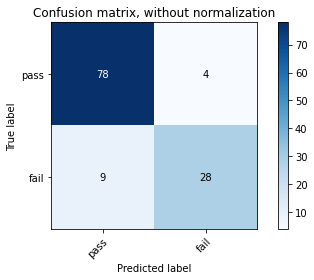

In [9]:
holdout(DecisionTreeClassifier(random_state=0), X, y_bi, ['pass', 'fail'])

- With five-class and holdout

              precision    recall  f1-score   support

   excellent       0.43      0.75      0.55         4
        good       0.73      0.52      0.61        21
satisfactory       0.39      0.79      0.52        14
  sufficient       0.57      0.37      0.45        43
        fail       0.68      0.76      0.72        37

    accuracy                           0.58       119
   macro avg       0.56      0.64      0.57       119
weighted avg       0.61      0.58      0.57       119

Confusion matrix, without normalization
[[ 3  1  0  0  0]
 [ 4 11  4  2  0]
 [ 0  2 11  1  0]
 [ 0  1 13 16 13]
 [ 0  0  0  9 28]]


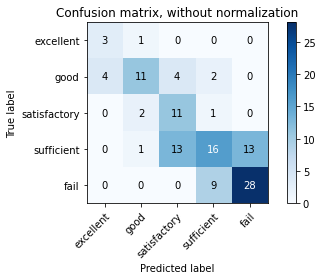

In [10]:
holdout(DecisionTreeClassifier(random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'])

- With binary label and kfold

              precision    recall  f1-score   support

        pass       0.89      0.88      0.88       265
        fail       0.76      0.77      0.77       130

    accuracy                           0.85       395
   macro avg       0.82      0.83      0.83       395
weighted avg       0.85      0.85      0.85       395

Confusion matrix, without normalization
[[234  31]
 [ 30 100]]


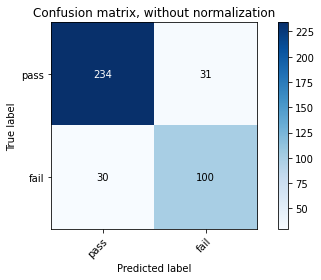

In [11]:
kfold(DecisionTreeClassifier(random_state=0), X, y_bi, ['pass', 'fail'], 3)

- With five-class and kfold

              precision    recall  f1-score   support

   excellent       0.72      0.72      0.73        40
        good       0.63      0.65      0.64        60
satisfactory       0.53      0.50      0.52        62
  sufficient       0.56      0.57      0.56       103
        fail       0.77      0.76      0.76       130

    accuracy                           0.65       395
   macro avg       0.64      0.64      0.64       395
weighted avg       0.65      0.65      0.65       395

Confusion matrix, without normalization
[[29 11  0  0  0]
 [11 39 10  0  0]
 [ 0 11 31 16  4]
 [ 0  1 17 59 26]
 [ 0  0  0 31 99]]


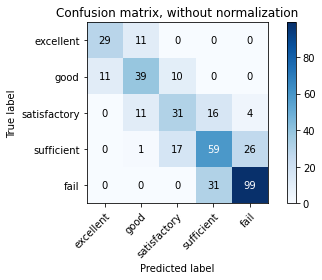

In [12]:
kfold(DecisionTreeClassifier(random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'], 3)

### Observation of Decision Tree Model
- The algorithm used here is CART
- Binary classification performs significantly better than five-class classification.
- Result did not differ much between holdout and kfold validation for binary classification, but for five-class kfold performed better.


### Randon Forest
- With binary label and holdout
- Comparing different number of estimator -- 3, 10, 100

              precision    recall  f1-score   support

        pass       0.85      0.85      0.85        82
        fail       0.68      0.68      0.68        37

    accuracy                           0.80       119
   macro avg       0.76      0.76      0.76       119
weighted avg       0.80      0.80      0.80       119

Confusion matrix, without normalization
[[70 12]
 [12 25]]


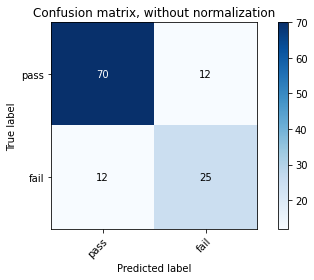

              precision    recall  f1-score   support

        pass       0.92      0.89      0.91        82
        fail       0.78      0.84      0.81        37

    accuracy                           0.87       119
   macro avg       0.85      0.86      0.86       119
weighted avg       0.88      0.87      0.88       119

Confusion matrix, without normalization
[[73  9]
 [ 6 31]]


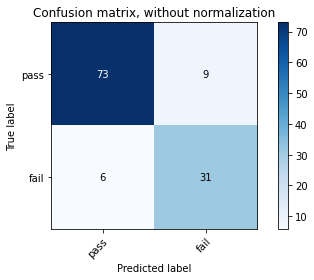

              precision    recall  f1-score   support

        pass       0.96      0.94      0.95        82
        fail       0.87      0.92      0.89        37

    accuracy                           0.93       119
   macro avg       0.92      0.93      0.92       119
weighted avg       0.93      0.93      0.93       119

Confusion matrix, without normalization
[[77  5]
 [ 3 34]]


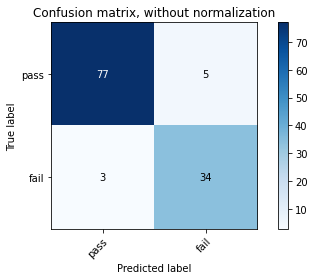

In [13]:
holdout(RandomForestClassifier(n_estimators=3, n_jobs= -1, random_state=0), X, y_bi, ['pass', 'fail'])
holdout(RandomForestClassifier(n_estimators=10, n_jobs= -1, random_state=0), X, y_bi, ['pass', 'fail'])
holdout(RandomForestClassifier(n_estimators=100, n_jobs= -1, random_state=0), X, y_bi, ['pass', 'fail'])

- With five-class and holdout
- Comparing different number of estimator: 3, 10, 100

              precision    recall  f1-score   support

   excellent       0.16      0.75      0.26         4
        good       0.30      0.14      0.19        21
satisfactory       0.12      0.14      0.13        14
  sufficient       0.71      0.35      0.47        43
        fail       0.63      0.89      0.74        37

    accuracy                           0.47       119
   macro avg       0.38      0.46      0.36       119
weighted avg       0.53      0.47      0.46       119

Confusion matrix, without normalization
[[ 3  1  0  0  0]
 [ 8  3  7  1  2]
 [ 7  4  2  1  0]
 [ 1  2  8 15 17]
 [ 0  0  0  4 33]]


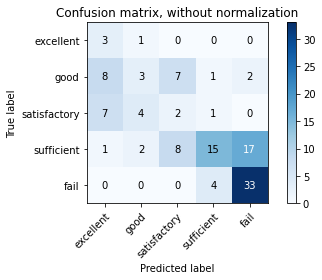

              precision    recall  f1-score   support

   excellent       0.33      1.00      0.50         4
        good       0.57      0.38      0.46        21
satisfactory       0.25      0.36      0.29        14
  sufficient       0.80      0.47      0.59        43
        fail       0.71      0.92      0.80        37

    accuracy                           0.60       119
   macro avg       0.53      0.62      0.53       119
weighted avg       0.65      0.60      0.59       119

Confusion matrix, without normalization
[[ 4  0  0  0  0]
 [ 6  8  7  0  0]
 [ 2  5  5  2  0]
 [ 0  1  8 20 14]
 [ 0  0  0  3 34]]


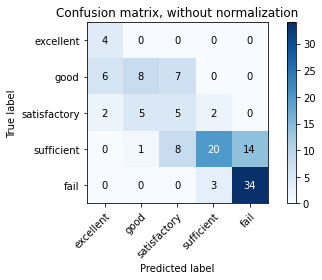

              precision    recall  f1-score   support

   excellent       0.50      0.75      0.60         4
        good       0.72      0.62      0.67        21
satisfactory       0.38      0.64      0.47        14
  sufficient       0.96      0.51      0.67        43
        fail       0.77      1.00      0.87        37

    accuracy                           0.71       119
   macro avg       0.66      0.70      0.66       119
weighted avg       0.77      0.71      0.71       119

Confusion matrix, without normalization
[[ 3  1  0  0  0]
 [ 3 13  5  0  0]
 [ 0  4  9  1  0]
 [ 0  0 10 22 11]
 [ 0  0  0  0 37]]


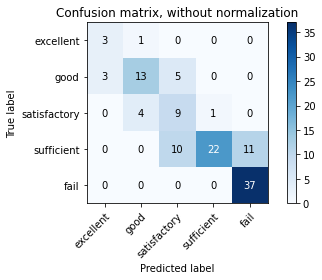

In [14]:
holdout(RandomForestClassifier(n_estimators=3, n_jobs= -1, random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'])
holdout(RandomForestClassifier(n_estimators=10, n_jobs= -1, random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'])
holdout(RandomForestClassifier(n_estimators=100, n_jobs= -1, random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'])

- With binary-label and kfold
- Comparing different number of estimator: 3, 10, 100

              precision    recall  f1-score   support

        pass       0.86      0.90      0.88       265
        fail       0.78      0.69      0.73       130

    accuracy                           0.83       395
   macro avg       0.82      0.80      0.81       395
weighted avg       0.83      0.83      0.83       395

Confusion matrix, without normalization
[[239  26]
 [ 40  90]]


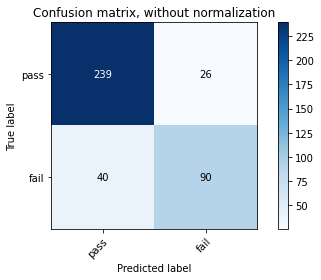

              precision    recall  f1-score   support

        pass       0.91      0.91      0.91       265
        fail       0.82      0.82      0.82       130

    accuracy                           0.88       395
   macro avg       0.86      0.87      0.87       395
weighted avg       0.88      0.88      0.88       395

Confusion matrix, without normalization
[[241  24]
 [ 23 107]]


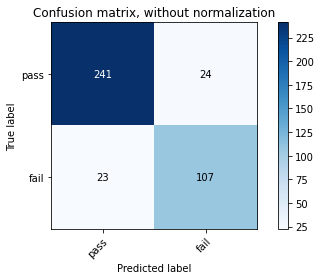

              precision    recall  f1-score   support

        pass       0.93      0.92      0.92       265
        fail       0.84      0.85      0.85       130

    accuracy                           0.90       395
   macro avg       0.88      0.89      0.89       395
weighted avg       0.90      0.90      0.90       395

Confusion matrix, without normalization
[[244  21]
 [ 19 111]]


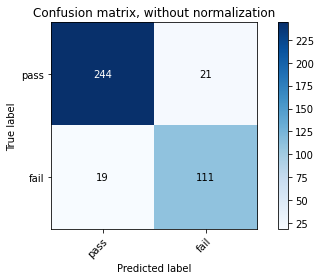

In [15]:
kfold(RandomForestClassifier(n_estimators=3, n_jobs= -1, random_state=0), X, y_bi, ['pass', 'fail'], 3)
kfold(RandomForestClassifier(n_estimators=10, n_jobs= -1, random_state=0), X, y_bi, ['pass', 'fail'], 3)
kfold(RandomForestClassifier(n_estimators=100, n_jobs= -1, random_state=0), X, y_bi, ['pass', 'fail'], 3)

- with five-class and kfold
- Comparing different number of estimator: 3, 10, 100

              precision    recall  f1-score   support

   excellent       0.31      0.45      0.37        40
        good       0.37      0.38      0.37        60
satisfactory       0.51      0.32      0.40        62
  sufficient       0.58      0.43      0.49       103
        fail       0.68      0.83      0.75       130

    accuracy                           0.54       395
   macro avg       0.49      0.48      0.48       395
weighted avg       0.54      0.54      0.53       395

Confusion matrix, without normalization
[[ 18  18   2   1   1]
 [ 23  23   7   3   4]
 [ 11  15  20   9   7]
 [  4   6  10  44  39]
 [  2   1   0  19 108]]


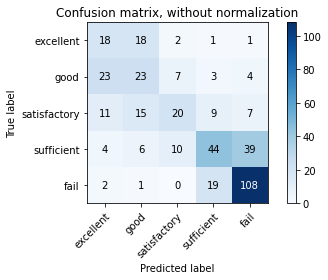

              precision    recall  f1-score   support

   excellent       0.50      0.40      0.44        40
        good       0.49      0.67      0.56        60
satisfactory       0.60      0.42      0.50        62
  sufficient       0.65      0.58      0.61       103
        fail       0.78      0.87      0.82       130

    accuracy                           0.65       395
   macro avg       0.60      0.59      0.59       395
weighted avg       0.64      0.65      0.64       395

Confusion matrix, without normalization
[[ 16  22   2   0   0]
 [ 14  40   5   1   0]
 [  2  17  26  15   2]
 [  0   3  10  60  30]
 [  0   0   0  17 113]]


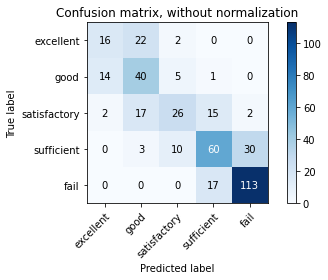

              precision    recall  f1-score   support

   excellent       0.74      0.50      0.60        40
        good       0.58      0.72      0.64        60
satisfactory       0.53      0.39      0.45        62
  sufficient       0.62      0.63      0.62       103
        fail       0.81      0.90      0.85       130

    accuracy                           0.68       395
   macro avg       0.66      0.63      0.63       395
weighted avg       0.68      0.68      0.67       395

Confusion matrix, without normalization
[[ 20  19   1   0   0]
 [  7  43   8   2   0]
 [  0  12  24  25   1]
 [  0   0  12  65  26]
 [  0   0   0  13 117]]


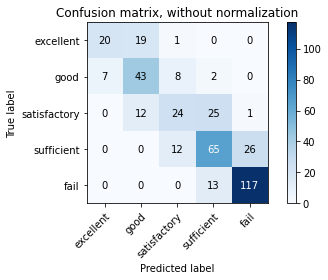

In [16]:
kfold(RandomForestClassifier(n_estimators=3, n_jobs= -1, random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'], 3)
kfold(RandomForestClassifier(n_estimators=10, n_jobs= -1, random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'], 3)
kfold(RandomForestClassifier(n_estimators=100, n_jobs= -1, random_state=0), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'], 3)

### Observation of Random Forest
- Binary classification performs significantly better than five-class classification.
- The model performed better with more number of estimators.
- For both binary and five-class classification, the result is better than decision tree model.
- Result did not differ much between holdout and kfold validation.
- Random forest select subset of the same training data to build each base estimator, however kfold means select different training data to built the whole model.

### KNN
- With binary-label and holdout
- Comparing different number of nearest neighbor: 5, 15, 30

              precision    recall  f1-score   support

        pass       0.92      0.87      0.89        82
        fail       0.74      0.84      0.78        37

    accuracy                           0.86       119
   macro avg       0.83      0.85      0.84       119
weighted avg       0.86      0.86      0.86       119

Confusion matrix, without normalization
[[71 11]
 [ 6 31]]


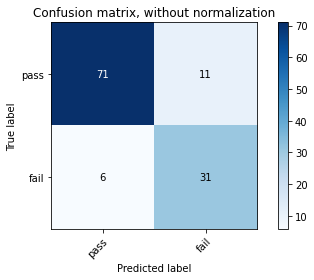

              precision    recall  f1-score   support

        pass       0.92      0.93      0.92        82
        fail       0.83      0.81      0.82        37

    accuracy                           0.89       119
   macro avg       0.87      0.87      0.87       119
weighted avg       0.89      0.89      0.89       119

Confusion matrix, without normalization
[[76  6]
 [ 7 30]]


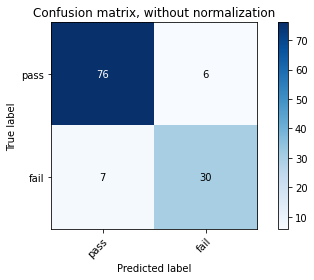

              precision    recall  f1-score   support

        pass       0.92      0.95      0.93        82
        fail       0.88      0.81      0.85        37

    accuracy                           0.91       119
   macro avg       0.90      0.88      0.89       119
weighted avg       0.91      0.91      0.91       119

Confusion matrix, without normalization
[[78  4]
 [ 7 30]]


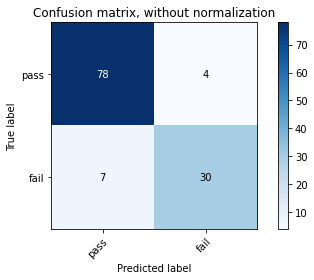

In [17]:
# X_normalized = normalize(X, norm='max', axis = 1)
holdout(KNeighborsClassifier(n_neighbors=5,  weights='distance', n_jobs= -1), X, y_bi, ['pass', 'fail'])
holdout(KNeighborsClassifier(n_neighbors=15, weights='distance', n_jobs= -1), X, y_bi, ['pass', 'fail'])
holdout(KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs= -1), X, y_bi, ['pass', 'fail'])

- With five-class and holdout
- Comparing different number of nearest neighbor: 5, 15, 30

              precision    recall  f1-score   support

   excellent       0.50      0.75      0.60         4
        good       0.67      0.67      0.67        21
satisfactory       0.12      0.14      0.13        14
  sufficient       0.62      0.42      0.50        43
        fail       0.70      0.86      0.77        37

    accuracy                           0.58       119
   macro avg       0.52      0.57      0.53       119
weighted avg       0.59      0.58      0.57       119

Confusion matrix, without normalization
[[ 3  0  1  0  0]
 [ 3 14  4  0  0]
 [ 0  6  2  6  0]
 [ 0  1 10 18 14]
 [ 0  0  0  5 32]]


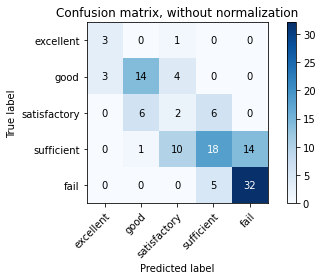

              precision    recall  f1-score   support

   excellent       0.33      0.50      0.40         4
        good       0.74      0.67      0.70        21
satisfactory       0.35      0.50      0.41        14
  sufficient       0.76      0.51      0.61        43
        fail       0.73      0.89      0.80        37

    accuracy                           0.66       119
   macro avg       0.58      0.61      0.59       119
weighted avg       0.68      0.66      0.66       119

Confusion matrix, without normalization
[[ 2  1  1  0  0]
 [ 4 14  3  0  0]
 [ 0  4  7  3  0]
 [ 0  0  9 22 12]
 [ 0  0  0  4 33]]


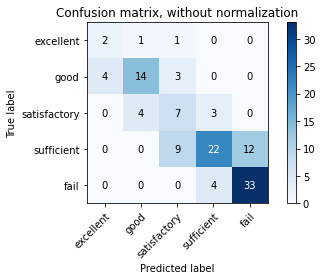

              precision    recall  f1-score   support

   excellent       0.40      0.50      0.44         4
        good       0.75      0.71      0.73        21
satisfactory       0.37      0.50      0.42        14
  sufficient       0.81      0.58      0.68        43
        fail       0.77      0.92      0.84        37

    accuracy                           0.70       119
   macro avg       0.62      0.64      0.62       119
weighted avg       0.72      0.70      0.70       119

Confusion matrix, without normalization
[[ 2  1  1  0  0]
 [ 3 15  3  0  0]
 [ 0  4  7  3  0]
 [ 0  0  8 25 10]
 [ 0  0  0  3 34]]


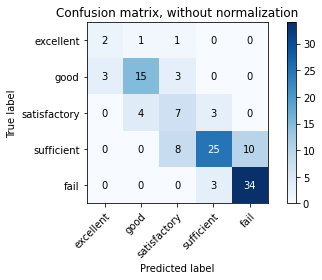

In [18]:
holdout(KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs= -1), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'])
holdout(KNeighborsClassifier(n_neighbors=15, weights='distance', n_jobs= -1), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'])
holdout(KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs= -1), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'])

- With binary-label and kfold
- Comparing different number of nearest neighbor: 5, 15, 30

              precision    recall  f1-score   support

        pass       0.90      0.89      0.90       265
        fail       0.78      0.81      0.79       130

    accuracy                           0.86       395
   macro avg       0.84      0.85      0.84       395
weighted avg       0.86      0.86      0.86       395

Confusion matrix, without normalization
[[235  30]
 [ 25 105]]


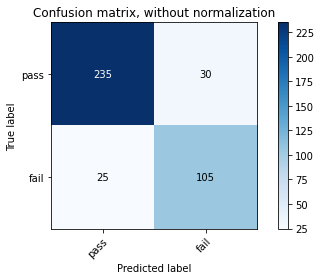

              precision    recall  f1-score   support

        pass       0.88      0.93      0.91       265
        fail       0.84      0.75      0.79       130

    accuracy                           0.87       395
   macro avg       0.86      0.84      0.85       395
weighted avg       0.87      0.87      0.87       395

Confusion matrix, without normalization
[[246  19]
 [ 32  98]]


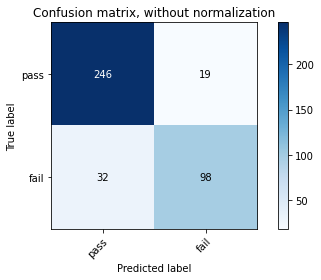

              precision    recall  f1-score   support

        pass       0.87      0.95      0.91       265
        fail       0.88      0.72      0.79       130

    accuracy                           0.87       395
   macro avg       0.87      0.83      0.85       395
weighted avg       0.87      0.87      0.87       395

Confusion matrix, without normalization
[[252  13]
 [ 37  93]]


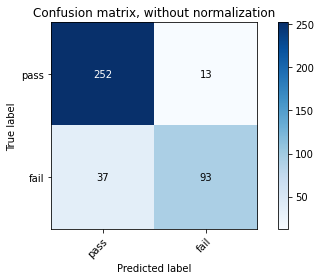

In [19]:
kfold(KNeighborsClassifier(n_neighbors=5,   weights='distance', n_jobs= -1), X, y_bi, ['pass', 'fail'], 3)
kfold(KNeighborsClassifier(n_neighbors=15,  weights='distance', n_jobs= -1), X, y_bi, ['pass', 'fail'], 3)
kfold(KNeighborsClassifier(n_neighbors=30,  weights='distance', n_jobs= -1), X, y_bi, ['pass', 'fail'], 3)

- With five-class and kfold
- Comparing different number of nearest neighbor: 5, 15, 30

              precision    recall  f1-score   support

   excellent       0.80      0.60      0.69        40
        good       0.61      0.70      0.65        60
satisfactory       0.43      0.40      0.42        62
  sufficient       0.54      0.51      0.52       103
        fail       0.76      0.81      0.78       130

    accuracy                           0.63       395
   macro avg       0.63      0.61      0.61       395
weighted avg       0.63      0.63      0.63       395

Confusion matrix, without normalization
[[ 24  14   2   0   0]
 [  6  42  11   1   0]
 [  0  12  25  23   2]
 [  0   1  17  53  32]
 [  0   0   3  22 105]]


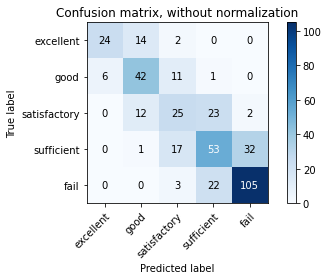

              precision    recall  f1-score   support

   excellent       0.95      0.47      0.63        40
        good       0.60      0.87      0.71        60
satisfactory       0.49      0.29      0.36        62
  sufficient       0.55      0.64      0.59       103
        fail       0.80      0.80      0.80       130

    accuracy                           0.66       395
   macro avg       0.68      0.61      0.62       395
weighted avg       0.67      0.66      0.65       395

Confusion matrix, without normalization
[[ 19  19   2   0   0]
 [  1  52   4   3   0]
 [  0  16  18  26   2]
 [  0   0  13  66  24]
 [  0   0   0  26 104]]


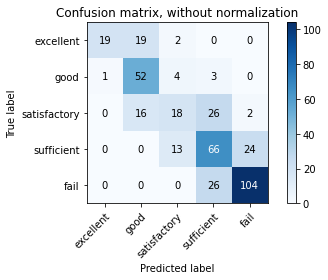

              precision    recall  f1-score   support

   excellent       0.93      0.35      0.51        40
        good       0.58      0.87      0.69        60
satisfactory       0.56      0.29      0.38        62
  sufficient       0.55      0.67      0.61       103
        fail       0.80      0.82      0.81       130

    accuracy                           0.66       395
   macro avg       0.69      0.60      0.60       395
weighted avg       0.68      0.66      0.64       395

Confusion matrix, without normalization
[[ 14  24   2   0   0]
 [  1  52   3   4   0]
 [  0  14  18  29   1]
 [  0   0   9  69  25]
 [  0   0   0  23 107]]


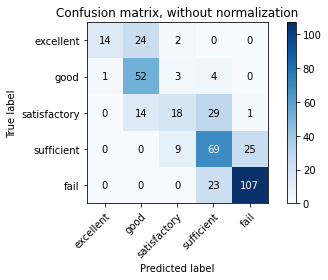

In [20]:
kfold(KNeighborsClassifier(n_neighbors=5,  weights='distance', n_jobs= -1), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'], 3)
kfold(KNeighborsClassifier(n_neighbors=15, weights='distance', n_jobs= -1), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'], 3)
kfold(KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs= -1), X, y_five, ['excellent', 'good', 'satisfactory', 'sufficient', 'fail'], 3)

### Observation of KNN
- Binary classification performs significantly better than five-class classification.
- The model performed slightly better with more number of neighbors.
- For both binary and five-class classification, knn performed similary with decision tree and random forest model.
- Result of holdout is slightly better than kfold validation.

### Questions
#### Decision Tree -- Show the prediction and reasoning of 1-samples in the validation set by visualization tree.

In [21]:
def holdout_plus_visualtree(clf, X, y, label):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
    clf.fit(X_train, y_train)
#     y_true, y_pred = y_valid, clf.predict(X_valid)
    
#     print(classification_report(y_true, y_pred, labels = label))
#     plot_confusion_matrix(y_true, y_pred, classes=np.array(label), cmap=plt.cm.Blues)
#     plt.show()
    
    dot_data = export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=clf.classes_,  
                     filled=True,
                     rounded=True,  
                     special_characters=True,
                     )  
    graph = graphviz.Source(dot_data)
    print('One data from validation set:')
    print('Feature:')
    print(X_valid.iloc[0])
    print('\nTrue label:')
    print(y_valid.iloc[0])
    print('\nPredict label:')
    print(clf.predict(X_valid.iloc[0].to_numpy().reshape(1, -1))[0])
    return graph

One data from validation set:
Feature:
age                  17
Medu                  4
Fedu                  3
traveltime            1
studytime             3
failures              0
famrel                4
freetime              2
goout                 2
Dalc                  1
Walc                  2
health                3
absences              0
G1                   15
G2                   15
school_GP             1
school_MS             0
sex_F                 1
sex_M                 0
address_R             0
address_U             1
famsize_GT3           1
famsize_LE3           0
Pstatus_A             0
Pstatus_T             1
Mjob_at_home          0
Mjob_health           1
Mjob_other            0
Mjob_services         0
Mjob_teacher          0
Fjob_at_home          0
Fjob_health           0
Fjob_other            0
Fjob_services         1
Fjob_teacher          0
reason_course         0
reason_home           0
reason_other          0
reason_reputation     1
guardian_father       0
g

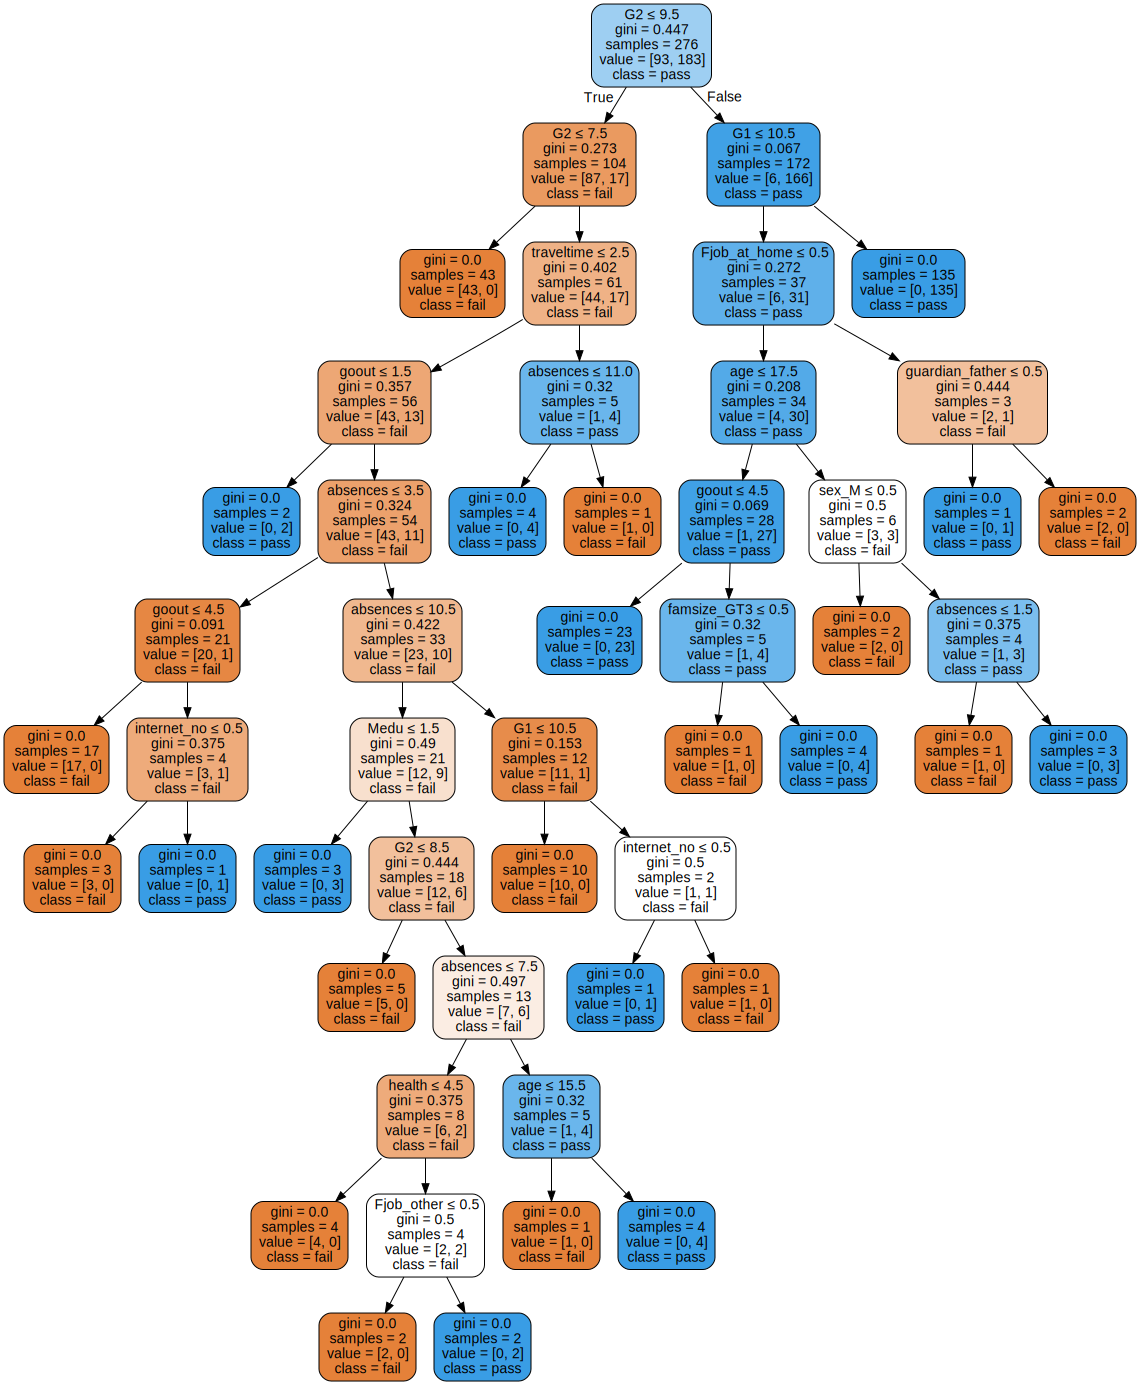

In [22]:
holdout_plus_visualtree(DecisionTreeClassifier(random_state=0), X, y_bi, ['pass', 'fail'])

#### According to the above figures and validation sample, we can see that the prediction follow the node path : <br>
- G2 ≤ 9.5: False --> G1 ≤ 10.5: False --> class = Pass

#### RandomForest -- Bagging vs Boosting
- Bagging
  By constructing several estimators on random subsets of the training data and then aggregate their individual predictions to form a final prediction.By doing so, we can potentially reduce the variance of a base estimator with introducing randomization into its construction procedure, hence reducing the chance of overfitting, and bagging methods perform better when using strong(complex) model.
- Boosting methods
  In boosting methods, base estimators are built one after another, and sequentially reduce the bias of the pervious estimator.The ideas is to combine many weak(simple) models to produce a more powerful ensemble model.
  

### Function for changing categorical labels to numeric value
> for matplot plotting purpose

In [23]:
def num_five(x):
    if x == 'excellent':
        return 4
    elif x == 'good':
        return 3
    elif x == 'satisfactory':
        return 2
    elif x == 'sufficient':
        return 1
    elif x == 'fail':
        return 0

#### KNN -- Pick 2 features, G1 and G2 to draw the decision boundaries.

#### Function for plotting KNN decision boundary
> reference from document on sklearn website

In [24]:
def drawknnbound(clf, X, y, train_test):
    step = 0.02  # step size in the mesh

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
    y_train = y_train.apply(lambda x: num_five(x))
    y_valid = y_valid.apply(lambda x: num_five(x))

    clf.fit(X_train[['G1', 'G2']], y_train)
#     y_true, y_pred = y_valid, clf.predict(X_valid)

    f1_min, f1_max = X_train.to_numpy()[:, 13].min() - 1, X_train.to_numpy()[:, 13].max() + 1
    f2_min, f2_max = X_train.to_numpy()[:, 14].min() - 1, X_train.to_numpy()[:, 14].max() + 1
    f1_cord, f2_cord = np.meshgrid(np.arange(f1_min, f1_max, step), np.arange(f2_min, f2_max, step))
    
    P = clf.predict(np.c_[f1_cord.ravel(), f2_cord.ravel()])
    P = P.reshape(f1_cord.shape)

    plt.figure(figsize=(9,7))
    plt.pcolormesh(f1_cord, f2_cord, P, cmap='Pastel1')

    if train_test == 'train':
        plt.scatter(X_train.to_numpy()[:, 13], X_train.to_numpy()[:, 14], c=y_train, cmap='Set1', edgecolor='k', s=30)
    else:
        print('One data from validation set:')
        print('Feature')
        print(X_valid.iloc[0,13:15])
        print('\nTrue label:', y_valid.iloc[0])
        predict = clf.predict(X_valid.iloc[0,13:15].to_numpy().reshape(1, -1))[0]
        print('Predict label:', predict)
        plt.scatter(X_valid.to_numpy()[0, 13], X_valid.to_numpy()[0, 14], cmap='Set1', edgecolor='k', s=30)
    
    plt.xlim(f1_cord.min(), f2_cord.max())
    plt.ylim(f2_cord.min(), f2_cord.max())
#     plt.title("3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.show()

#### Draw the decision boundary and plot training datas

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


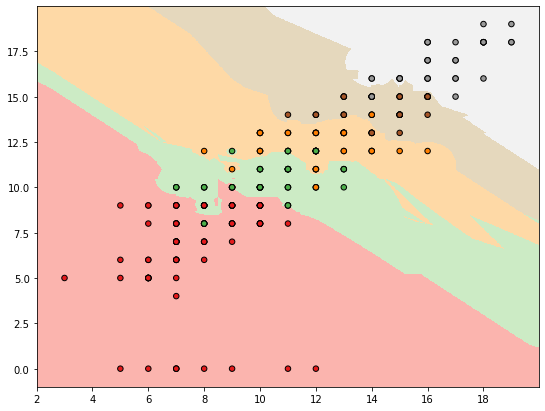

In [25]:
drawknnbound(KNeighborsClassifier(n_neighbors= 15, weights='distance', n_jobs= -1), X, y_five, 'train')

- Show the prediction and reasoning of 1-samples in the validation set by drawing the decision boundary with one validation data sample

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


One data from validation set:
Feature
G1    15
G2    15
Name: 329, dtype: int64

True label: 3
Predict label: 3


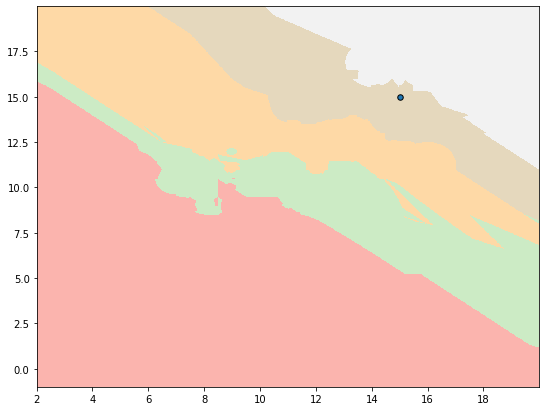

In [26]:
drawknnbound(KNeighborsClassifier(n_neighbors= 15, weights='distance', n_jobs= -1), X, y_five, 'test')

#### As we can see from the above figure and output cell, the classifier predict the validation sample with feature value (15, 15) to be label = 3 (good), by plotting  the sample we can see it is in the brown area correspond to prediction = 3, and the True label value of sample data is indeed 3, meaning the prediction is correct.
> ps. label from 0-4, correspond to Erasmus grad conversion system's fail-good